# Introduction to Text Generation Parameters

## Theory

**Temperature**  controls randomness in predictions (low=temporary, high=creative)

**Decoding Strategies** are the methods for sampling from probability distributions
- Greedy Search: chooses a token with the highest probability
- Beam-search: keeps several hypotheses at each time step and eventually chooses the hypothesis that has the overall highest probability for the entire sequence
- Multinomial sampling: randomly selects the next token based on the probability distribution over the entire vocabulary

**Decoding params:**
- Top-k: limits to k highest probability tokens
- Top-p: limits to tokens comprising top p probability mass

https://huggingface.co/docs/transformers/generation_strategies


<img src = https://raw.githubusercontent.com/lwtztea/ml_pic/9211f0d/week_5/token_generation.png width = 1000 >

<img src = https://raw.githubusercontent.com/lwtztea/ml_pic/9211f0d/week_5/temperature.png width = 700 >

## Practice

In [1]:
import matplotlib.pyplot as plt
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [2]:
MODEL_NAME = "gpt2"
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### Temperature Exploration

In [3]:
def generate_with_temperature(prompt, temperature=1.0, max_length=50):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_length,
        temperature=temperature,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [4]:
PROMPT = "The future of artificial intelligence is"
print("TEMPERATURE 0.2:\n", generate_with_temperature(PROMPT, 0.2), end="\n\n")
print("TEMPERATURE 0.7:\n", generate_with_temperature(PROMPT, 0.7), end="\n\n")
print("TEMPERATURE 1.2:\n", generate_with_temperature(PROMPT, 1.2), end="\n\n")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


TEMPERATURE 0.2:
 The future of artificial intelligence is in the hands of a group of researchers who believe that the future of artificial intelligence is in the hands of a group of researchers who believe that the future of artificial intelligence is in the hands of a group of people who believe

TEMPERATURE 0.7:
 The future of artificial intelligence is in the hands of the next generation of researchers.

"When you look at robotics and AI, we already have a lot of experience in that field," said Mark Herrmann, a research professor at MIT who

TEMPERATURE 1.2:
 The future of artificial intelligence is not a question of the potential of science. The technology is a necessity of human civilisation as one of its vital forces, as a result of a great shift in society in the years ahead. Indeed, it is now clear



### Decoding Strategy Comparison

Let's compare different text generation strategies (decoding methods) for a given prompt using a pre-trained language model.

We want to try four different decoding strategies:

- Greedy Search: Selects the most likely next token at each step.

- Beam Search (4 beams): Explores multiple sequences simultaneously, keeping the top 4 most likely sequences.

- Top-k Sampling (k=50): Samples the next token from the top 50 most likely tokens.

- Top-p Sampling (p=0.9): Samples the next token from the smallest set of tokens whose cumulative probability exceeds 0.9.

In [5]:
def compare_decoding_strategies(prompt):
    strategies = {
        "Greedy": {
            "do_sample": False,
        },
        "Beam Search (4 beams)": {
            "num_beams": 4,
            "early_stopping": True,
        },
        "Top-k (k=50)": {
            "do_sample": True,
            "top_k": 50,
        },
        "Top-p (p=0.9)": {
            "do_sample": True,
            "top_p": 0.9,
        },
    }

    for name, params in strategies.items():
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        outputs = model.generate(
            inputs.input_ids,
            max_length=50,
            pad_token_id=tokenizer.eos_token_id,
            **params,
        )
        print(f"\n--- {name} ---\n{tokenizer.decode(outputs[0], skip_special_tokens=True)}")

In [6]:
compare_decoding_strategies("Machine learning workshops help people")


--- Greedy ---
Machine learning workshops help people learn how to use the Internet to solve problems.

The workshop is open to anyone who wants to learn how to use the Internet to solve problems.

The workshop is open to anyone who wants to learn how to

--- Beam Search (4 beams) ---
Machine learning workshops help people learn how to use machine learning to solve real-world problems.

In this workshop, you'll learn how to use machine learning to solve real-world problems.

Learn how to use machine learning to solve real

--- Top-k (k=50) ---
Machine learning workshops help people realize the importance of identifying patterns. Each of our events are customized in ways different from other groups on campus that can be applied to all phases of your life – with one-on-one sessions and full-time opportunities.

--- Top-p (p=0.9) ---
Machine learning workshops help people build a stronger, more intelligent and more collaborative computer.


### Temperature / Entropy Visualization

Let's analyze the effect of temperature on the entropy of a language model's predictions for a given prompt.

Let's see how changing the temperature parameter affects the entropy (uncertainty) of the model's predictions. Temperature is a hyperparameter used to control the randomness of predictions during text generation.

In [7]:
def plot_temperature_effect():
    prompt = "The best way to learn NLP is"
    temperatures = [0.1, 0.5, 1.0, 1.5, 2.0]
    entropies = []

    for temp in temperatures:
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits[0, -1, :] / temp, dim=-1)  # Look at Me!
        entropy = -torch.sum(probs * torch.log(probs)).item()
        entropies.append(entropy)

    plt.plot(temperatures, entropies, marker="o")
    plt.xlabel("Temperature")
    plt.ylabel("Entropy")
    plt.title("Temperature vs Prediction Entropy")
    plt.show()

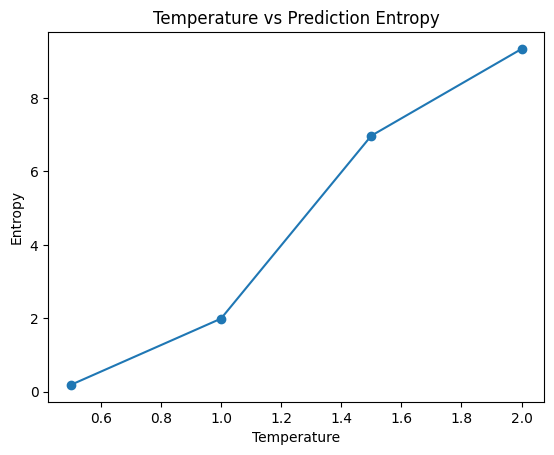

In [8]:
plot_temperature_effect()